<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 2 - Aplicaciones Recientes de Redes Neuronales </H3>
<H3 align='center'> Pregunta 1 - RNN sobre texto</H3>
<hr style="height:2px;border:none"/>

**Librerías**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive

**Dataset**

In [0]:
drive.mount('/content/gdrive')

In [0]:
fname = 'gdrive/My Drive/Colab Notebooks/ner.csv'
df_ner = pd.read_csv(fname, encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)

b'Skipping line 281837: expected 25 fields, saw 34\n'


## a)
**Lema vs Palabra**

Un lema es la base con significado de las palabras, por lo tanto no incluye inflexiones por persona, número, genero u otras. Por esto, al usar los lemas en vez de las palabras tal cual están en las frases, se obtiene un diccionario o vocabulario más reducido del dataset sin perder mucho significado.

<br/>

**Dimensiones dataset**

El dataset se compone de 655.408 lemas en total, a partir de 14.287 lemas únicos. Existen 17 etiquetas únicas y excluyentes entre sí, en las que se clasifican los lemas.

Considerando la organización en sentencias del dataset, se tiene que está compuesto por 30.000 frases de largo variable entre sí. El largo promedio es de 21,8 palabras o lemas, con un máximo de 70 lemas, aunque, sólo dos frases alcanzan este largo. 

In [0]:
dataset = df_ner.loc[:,["lemma","word","pos","tag", "prev-iob"]]
print("dataset.shape:", dataset.shape)
dataset.head()

dataset.shape: (1050794, 5)


,lemma,word,pos,tag,prev-iob
0,thousand,Thousands,NNS,O,__START1__
1,of,of,IN,O,O
2,demonstr,demonstrators,NNS,O,O
3,have,have,VBP,O,O
4,march,marched,VBN,O,O


In [0]:
n_used = 655409 # 30,000 sentences
dataX_raw,dataY_raw = [],[]
lemmas,labels = set(), set()  #uniques
sentence= []
labels_sentence = []
for fila in dataset.values[:n_used]:
    if fila[-1]=="__START1__":
        dataX_raw.append(sentence)
        dataY_raw.append(labels_sentence)
        sentence= []
        labels_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[3])
    sentence.append(fila[0]) #add lemma
    labels_sentence.append(fila[3]) #TAG    
dataX_raw = dataX_raw[1:]
dataY_raw = dataY_raw[1:]

sentences_len = pd.Series([len(x) for x in dataX_raw])

In [0]:
print("Número total de lemmas: {}".format(sentences_len.sum()))
print("         #Lemas únicos: {}".format(len(lemmas)))
print("     #Etiquetas únicas: {}".format(len(labels)))
print()
print("Número de frases: {}".format(len(sentences_len)))
print("  Largo promedio: {:.1f}".format(sentences_len.mean()))
print("    Largo máximo: {}    (#frases: {})".format(sentences_len.max(), sentences_len.value_counts()[70]))

Número total de lemmas: 655408
         #Lemas únicos: 14287
     #Etiquetas únicas: 17

Número de frases: 30000
  Largo promedio: 21.8
    Largo máximo: 70    (#frases: 2)


## b)  Largo sentencias y frecuencia lemas


### Distribución del largo de sentencias

En el histograma más abjo se aprecia que la mayoría de las sentencias del dataset se componen de entre 10 a 30 palabras, promediando un largo de alrededor de 20. También se observa una cola en la distribución con frases de largo mayor, alcanzando un máximo de 70 palabras. Esto implica que al hacer _padding_, una cantidad importante de frases van a contener más _tokens_ de _padding_ que palabras originales de la frase. 

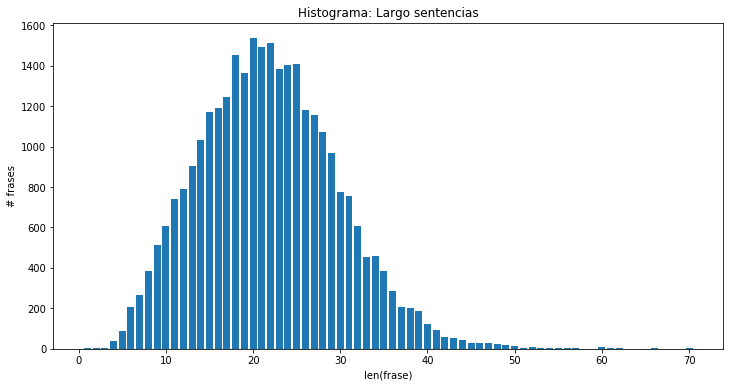

In [0]:
# Distro longitud sentencias
sent_len_hist = sentences_len.value_counts().sort_index()
bins = sent_len_hist.index

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(bins, sent_len_hist.values)
ax.set_xlabel('len(frase)')
ax.set_ylabel('# frases')
ax.set_title("Histograma: Largo sentencias")
plt.show()

### Frecuencia lemas & zipf's law

A continuación se grafica la distribución de probabilidad de la frecuencia de cada lema en el dataset completo. Se puede apreciar que la frecuencia de cada lema es aproximadamente al inverso del ranking según frecuencia de dicho lema, aunque con un _shift_ vertical. Por lo que esta distribución sigue una ley de Zipf.

En el gráfico se agregaron tres distribuciones de zipf con parámetros $a_1=0.8$, $a_2 = 1$ y $a_3 = 1.2$ para comparar con la distribución del dataset.

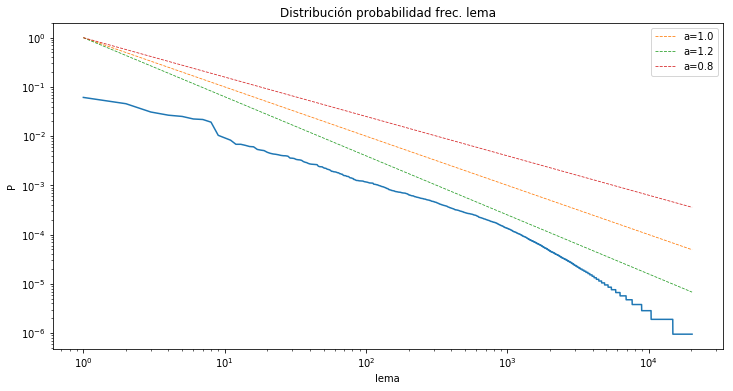

In [0]:
# zipf's law
zipf_i = lambda a, i : 1/np.power(i,a)
vzipf = np.vectorize(zipf_i)

# Frecuencia palabras (lemma)
lemma_pmf = dataset["lemma"].value_counts(normalize=True)

# PLOT
bins = range(1, lemma_pmf.count()+1)
fig, ax = plt.subplots(figsize=(12, 6))
ax.loglog(bins, lemma_pmf.values)
ax.loglog(bins, vzipf(1, bins), '--', lw=0.8, label="a={:1.1f}".format(1))
ax.loglog(bins, vzipf(1.2, bins), '--', lw=0.8, label="a={:1.1f}".format(1.2))
ax.loglog(bins, vzipf(.8, bins), '--', lw=0.8, label="a={:1.1f}".format(0.8))
ax.set_xlabel('lema')
ax.set_ylabel('P')
ax.set_title("Distribución probabilidad frec. lema")
plt.legend()
plt.show()

### Frecuencia tags

Se observa que cerca del $84\%$ de ocurrencias son del tag 'O' que pertenece a las palabras o lemas que no describen una entidad, que, como es de esperar,  corresponde a la gran mayoría de las palabras en el dataset.

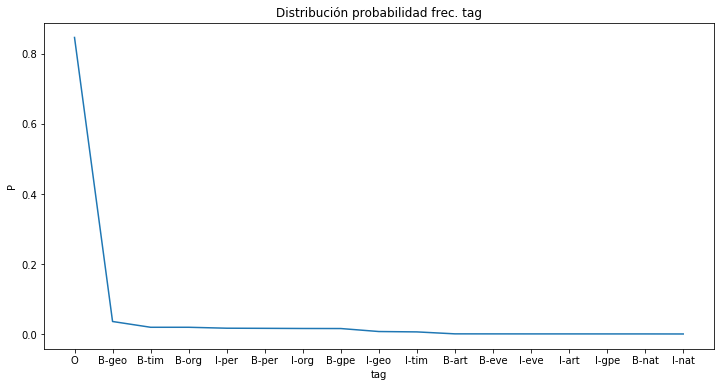

In [0]:
# Frecuencia tags
tag_pmf = dataset["tag"].value_counts(normalize=True)

# PLOT
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(tag_pmf.index, tag_pmf.values)
#ax.set_yscale('log')
ax.set_xlabel('tag')
ax.set_ylabel('P')
ax.set_title("Distribución probabilidad frec. tag")
plt.show()

In [0]:
tag_pmf

O        0.846953
B-geo    0.035711
B-tim    0.019217
B-org    0.019208
I-per    0.016542
B-per    0.016189
I-org    0.015738
B-gpe    0.015600
I-geo    0.007051
I-tim    0.005994
B-art    0.000413
B-eve    0.000331
I-eve    0.000283
I-art    0.000266
I-gpe    0.000218
B-nat    0.000215
I-nat    0.000072
Name: tag, dtype: float64

## c) Codificación de _tags_ y _lemmas_

Se codifica cada lema y tag con un índice para poder modelar el ejercicio. Hay 14.287 lemas y 17 tags únicos en la fracción del dataset a usar. En la siguiente sección, se agrega un token más para realizar el _padding_ y dejar las frases del mismo largo.

Se tiene, además, que la longitud máxima encontradas entre las sentencias es de 70 lemas.

In [0]:
n_labels = len(labels)
lab2idx = {t: i for i, t in enumerate(labels)}
dataY = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY_raw] #Converting tags to indexs
n_lemmas = len(lemmas)
lemma2idx = {w: i for i, w in enumerate(lemmas)} 
dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX_raw] #Converting text to indexs

In [0]:
print(" total tags distintos: {}".format(n_labels))
print("total lemas distintos: {}".format(n_lemmas))
print("Longitud máxima de sentencias: {}".format(max(sentences_len)))

 total tags distintos: 17
total lemas distintos: 14287
Longitud máxima de sentencias: 70


## d) pre-_padding_

En el paper Dwarampudi & Reddy (2019). "Effects of padding on LSTMs and CNNs" [[1]](#refs), los autores, encuentran que en redes LSTM, el _accuracy_ del modelo es mejor usando _pre-padding_ en las secuencias. Realizaron las pruebas con un problema de clasificación de _tweets_ (mensajes positivos o negativos) preparando los ejemplos con _pre-padding_ y _post-padding_ y probaron el _accuracy_ de modelos usando redes LSTM y CNN. Según los resultados que obtuvieron, para redes LSTM el _accuracy_ con _pre-padding_ fue de $80.3%$ y con _post-padding_ fue de $50.1%$ con los conjuntos de ejemplo de test. Para redes CNN no encontraron diferencia y el _accuracy_ logrado fue de alrededor de $74$. Por este motivo, se decide usar _pre-padding_.

Por otro lado, como ya se analizó en la sección b), la mayoría de las frases tienen longitud de entre 10 y 30 lemas. Sin embargo, la longitud máxima encontrada es de 70 lemas. Es decir, una gran cantidad de frases van a tener la mitad o más de su longitud rellenados con el token de _padding_. Esto implica que, con el _padding_ se va a agregar mucho costo al procesamiento del modelo.

In [0]:
from keras.preprocessing import sequence

Using TensorFlow backend.


In [0]:
lemma2idx["_PRE-PADDING_"] = n_lemmas #add fullfill lemma and tag to the dictionary
lab2idx["_PRE-PADDING_"] = n_labels
n_labels +=1
n_lemmas +=1

X = sequence.pad_sequences(dataX, maxlen=max(sentences_len), padding='pre', value=lemma2idx["_PRE-PADDING_"])
y = sequence.pad_sequences(dataY, maxlen=max(sentences_len), padding='pre', value=lab2idx["_PRE-PADDING_"])
del dataY[:],dataX[:]
del dataY, dataX

In [0]:
print("Código lemma pre-padding: {}".format(lemma2idx["_PRE-PADDING_"]))
print("   Tag lemma pre-padding: {}".format(lab2idx["_PRE-PADDING_"]))

Código lemma pre-padding: 14287
   Tag lemma pre-padding: 17


## e) Word2Vec

En el siguiente código se usa el módulo `word2vec` de `gensim` para mapear las palabras del _corpus_ a un espacio vectorial. Específicamente, se utiliza el modelo _skip-gram_ que consiste en una capa escondida de $N_{\text{embeddings}}$ neuronas lineales y una capa de salida _softmax_ con un número de neuronas igual a la cantidad de lemas únicos en el diccionario. El parámetro $N_{\text{embeddings}}$ corresponde al número de _embeddings_ y la dimensión del espacio vectorial.

La red se entrena usando pares de palabras, con la palabra _target_ (input de la red) y con la palabra _output_ que debe entregar la red. Para cada palabra (_target_) en cada documento de entrenamiento se toma un conjunto de $n$ palabras (_window size_) que antecede al _target_ y $n$ palabras que le suceden. Este conjunto forma el contexto del _target_ y los pares de palabras de entrenamiento se obtienen formando pares con el _target_ y cada una de las palabras en su contexto.

Una vez entrenada, la red debe dar como _output_ la probabilidad de cada una de las palabras del _corpus_ pertenezca al contexto de la palabra que se le entrega como _imput_.

En esta red neuronal, lo que realmente importan son los pesos de las neuronas en la capa escondida. Representando esta capa como una matriz de dimensión $N_{\text{lemmas}}\times N_{\text{embeddings}}$, cuyo contenido son los pesos de las neuronas, la fila i-ésima, de esta matriz, corresponde a la representación vectorial de la palabra i-ésima del _corpus_. Por como se entrena este modelo, si dos palabras tienen contexto similar, entonces, van a tener vectores muy cercanos o similares.

En el código siguiente, se especifica además el parámetro `min_count = 3` que deja fuera del modelo todos los lemas con frecuencia menor a la especificada. En esta sección en concreto, se dejan afuera los lemas con frecuencia menor a 3, por lo que, el total de lemas que se usan para generar su representación vectorial es de 8.008 (56% del total).




In [0]:
from gensim.models import Word2Vec

In [0]:
EMBEDDING_DIM = 32
window_size = 5
nb_epoch = 5
batch_size = 6000
min_count = 3
model = Word2Vec(dataX_raw, size=EMBEDDING_DIM, window=window_size, 
                 batch_words=batch_size, iter=nb_epoch, min_count=min_count, 
                 negative=5, sg=1) #sg=1 mean skip-gram

embeddings_index = {vocab_word: model.wv[vocab_word] for vocab_word in model.wv.vocab}


In [0]:
aux1 = dataset[:n_used]["lemma"].value_counts()
aux_c = aux1[aux1<min_count].size
print("Número total de lemmas:", n_lemmas-1) # menos token padding
print("Lemas con frecuencia >= {}: {}".format(min_count, n_lemmas - 1 - aux_c))
print("lemas mantenidos por Word2Vec: {}".format(len(embeddings_index.keys())))
del aux1, aux_c

Número total de lemmas: 14287
Lemas con frecuencia >= 3: 8008
lemas mantenidos por Word2Vec: 8008


A continuación, se crea la matriz de _embeddings_, para todo el _corpus_, agregando vectores $\vec{0}$ a la matriz generada por `Word2vec` por cada lema que fue descartado en el paso anterior (por tener frecuencia menor a `min_count`).

In [0]:
embedding_matrix = np.zeros((n_lemmas, EMBEDDING_DIM))
for word, i in lemma2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Finalmente, se crean los  _one-hot vectors_ para las secuencias de salidas de entrenamiento. Esto quiere decir que los tags en las secuencias de salida serán transformados en vectores de dimensión `n_labels` con valor $1$ en la posición correspondiente al _id_ del tag y $0$ en las otras posiciones.


In [0]:
from keras.utils import to_categorical
y_cat = np.asarray([to_categorical(i, num_classes=n_labels) for i in y])
y_cat.shape

(30000, 70, 18)

## f) Conjuntos de entrenamiento y de prueba

El dataset, de 30.000 frases o secuencias, es dividido con el 60% para el conjunto de entrenamiento, 20% para el conjunto de validación y  20% para el conjunto de prueba. De esta forma el _input_ de entrenamiento queda con 18.000 secuencias, todas de largo 70 (por el _pre-padding_ hecho previamente), y el _output_ del entrenamiento corresponden a 18.000 matrices de dimensiones 70 x 18 (largo de secuencia x número de tags o clases). Similar a lo anterior para los conjuntos de vaidación y de prueba, pero con 6.000 secuencias cada uno.


In [0]:
from sklearn.model_selection import train_test_split
X_aux, X_test, y_aux, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=22)
X_train, X_val, y_train, y_val = train_test_split(X_aux, y_aux, test_size=0.25, random_state=22)

In [0]:
print("Dimensiones conjunto entrenamiento:\n   X = {}\n   Y = {}\n".format(X_train.shape, y_train.shape))
print("Dimensiones conjunto validación:\n   X = {}\n   Y = {}\n".format(X_val.shape, y_val.shape))
print("Dimensiones conjunto prueba:\n   X = {}\n   Y = {}".format(X_test.shape, y_test.shape))

Dimensiones conjunto entrenamiento:
   X = (18000, 70)
   Y = (18000, 70, 18)

Dimensiones conjunto validación:
   X = (6000, 70)
   Y = (6000, 70, 18)

Dimensiones conjunto prueba:
   X = (6000, 70)
   Y = (6000, 70, 18)


## g) Red LSTM con pesos pre-calculados por `Word2Vec`.

### Entrenamiento modelo

El siguiente modelo se compone de una capa de _embeddings_, una capa recurrente LSTM y una capa densa _softmax_ de 18 neuronas que se aplica a cada paso de las secuencias por medio del _wraper_ `keras.layers.TimeDistributed(layer)`.

La capa de _embedding_ hace el mapeo de cada lema en la secuencia de entrada al espacio vectorial de 32 dimensiones. Los pesos (o _word vectors_) son los valores ya calculados con `Word2Vec`. La dimensión de _embeddings_ es de 32 y el _corpus_ contiene 14.287 lemas únicos, luego, se tienen 457.216 pesos en esta capa, los que no serán entrenados más en esta fase.

Luego, viene la capa recurrente de compuertas LSTM. Se define con 100 unidades. Su _output_ tendrá dimensión `batch x 70 x 100`. En esta capa se tienen 53.200 parámetros entrenables.

Finalmente, se tiene la capa _output_ como una capa densa _softmax_ que se aplica en cada paso de la secuencia, haciendo que esta red sea _many-to-many_. La capa tiene 18 neuronas, que es el número de etiquetas únicas, y por cada lema en la secuencia de entrada se devuelve la probabilidad de que pertenezca a una de las 18 etiquetas. En esta capa se tienen 1.818 parámetros entrenables que corresponden a los pesos y biases de las 18 neuronas para los 100 datos de entrada que le pasa la capa anterior.

El modelo tiene en total 55.018 parámetros entrenables y demora alrededor de cuatro minutos en ser entrenado usando google colab con GPU activado.

In [0]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout,TimeDistributed

In [0]:
max_input_lenght=max(sentences_len) # Largo de secuencias: 70 lemas fijo.

model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=False, weights = [embedding_matrix]))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 32)            457216    
_________________________________________________________________
lstm_2 (LSTM)                (None, 70, 100)           53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 70, 18)            1818      
Total params: 512,234
Trainable params: 55,018
Non-trainable params: 457,216
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=128)

Train on 18000 samples, validate on 6000 samples
Epoch 1/15
18000/18000 [==============================] - 17s 967us/step - loss: 0.3808 - val_loss: 0.2595
Epoch 2/15
18000/18000 [==============================] - 16s 912us/step - loss: 0.2190 - val_loss: 0.1757
Epoch 3/15
18000/18000 [==============================] - 16s 902us/step - loss: 0.1595 - val_loss: 0.1381
Epoch 4/15
18000/18000 [==============================] - 16s 907us/step - loss: 0.1341 - val_loss: 0.1208
Epoch 5/15
18000/18000 [==============================] - 16s 897us/step - loss: 0.1205 - val_loss: 0.1111
Epoch 6/15
18000/18000 [==============================] - 16s 916us/step - loss: 0.1116 - val_loss: 0.1030
Epoch 7/15
18000/18000 [==============================] - 16s 890us/step - loss: 0.1049 - val_loss: 0.0980
Epoch 8/15
18000/18000 [==============================] - 16s 885us/step - loss: 0.0998 - val_loss: 0.0929
Epoch 9/15
18000/18000 [==============================] - 16s 893us/step - loss: 0.0956 - val_l

### Evaluación modelo

Se utiliza el modelo para predecir los tag sobre el conjunto de testing elaborado anterioremente. Antes de evaluar el resultado, se elimina el _pre-tagging_ en los arreglos con las predicciones, `y_pred`, y con los valores reales, `y_true`, para evitar que se evalue el _tagging_ como parte de la predicción del modelo. 

Luego, se procede a comparar el número de tags presentes en los valores reales con el número de tags predichos por el modelo. Se observa que existen 17 tags únicos en el set, pero el modelo sólo predice 10 de estos tags. Además, en varias secuencias predichas, el modelo devolvió más _pre-padding_ que el real por lo que este tag especial aparece en el set de tags predichos pero no está presente en el set de tags reales.

Lo anterior genera un problema al calcular el _f1-score_ del modelo, pues hay tags que no tienen ejemplos predichos, así como, hay un tag predicho (el _pre-tagging_) que no existe entre los valores reales. La función `f1_score` de la librería `sklearn` resuelve con valor $0.0$ los casos estos casos conflictivos para poder calcular el puntaje.

Por último, se debe recordar que se tiene un importante desbalance en la cantidad de ejemplos para cada tag. Como se vió en la sección b), el tag 'O' representa más del 80% de los ejemplos. Este tag corresponde a las palabras o tokens que no identifican a alguna identidad (persona, lugar, tiempo, entidad geográfica, entidad geopolitica, etc). Para evitar que la sobrerepresentación de este tag influya tanto en el resultado del _f1-score_ se utiliza _macro-average_ como parte del calculo. Con este método, se calcula el puntaje para cada tag por separado y se promedian los resultados, con esto, cada tag aporta con el mismo peso al puntaje final. Si se usara el método _micro-average_, al calcular sobre todos los ejemplos directamente, cada ejemplo aporta individualmente al puntaje sin ser separado por clase o tag, resultando en que el tag 'O' tenga mucho más peso en el _score_ que el resto de los tags que son más importantes.

Entonces, con el parámetro `average='macro'`, se tiene que el puntaje obtenido por el modelo es de $0.727$

In [0]:
from sklearn.metrics import f1_score

In [0]:
# Construccion y_true
dataY = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY_raw]
_, y_true = train_test_split(dataY, test_size=0.2, random_state=22)
del dataY[:], dataY

# Prediccion modelo
dataY_pred = model.predict_classes(X_test,verbose=0)
y_pred = [dataY_pred[i][-len(y_true[i]):] for i in range(len(dataY_pred))]

# labels unicos en cada set.
uniq_true = set()
uniq_pred = set()
for i in range(len(y_pred)):
  if len(y_pred[i]) != len(y_true[i]):
    print("ERROR {}, {} - {}".format(i, len(dataY_pred[i]), len(dataY[i])))
  for j in range(len(y_true[i])):
    uniq_true.add(y_true[i][j])
    uniq_pred.add(y_pred[i][j])

print("labels in y_true: {}".format(uniq_true))
print("labels in y_pred: {}".format(uniq_pred))
print("----\n")

#F1 score
f1_score_bydata = [f1_score(true, pred ,average='macro') for true, pred in zip(y_true, y_pred) ]
print("\n\nF1 score on test: ", np.mean(f1_score_bydata) )

labels in y_true: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
labels in y_pred: {0, 2, 3, 4, 8, 9, 10, 11, 12, 13, 17}
----



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)




F1 score on test:  0.726802154786343


## h) Red LSTM entrenando _embeddings_

### Entrenamiento modelo

En este modelo se agrega la capa de _embeddings_ al entrenamiento. El punto de partida de esta capa (inicialización de pesos) son los pesos encontrados con `Word2Vec`. En este nuevo modelo, se tienen 512.234 parámetros en total. De estos, 457.216 (89,3%) parámetros corresponden a la capa de _embeddings_,

La ejecución del entrenamiento tarda entre un poco más de cuatro minutos a cuatro minutos y medios en google colab con GPU activado. Lo que da, un aumento de entre 10s a 30s más de ejecución con respecto al modelo anterior.

In [0]:
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=True, weights = [embedding_matrix]))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 70, 32)            457216    
_________________________________________________________________
lstm_3 (LSTM)                (None, 70, 100)           53200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 70, 18)            1818      
Total params: 512,234
Trainable params: 512,234
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=128)

Train on 18000 samples, validate on 6000 samples
Epoch 1/15
18000/18000 [==============================] - 18s 1ms/step - loss: 0.7150 - val_loss: 0.2790
Epoch 2/15
18000/18000 [==============================] - 17s 971us/step - loss: 0.2259 - val_loss: 0.1660
Epoch 3/15
18000/18000 [==============================] - 17s 943us/step - loss: 0.1374 - val_loss: 0.1077
Epoch 4/15
18000/18000 [==============================] - 17s 950us/step - loss: 0.0943 - val_loss: 0.0790
Epoch 5/15
18000/18000 [==============================] - 17s 944us/step - loss: 0.0730 - val_loss: 0.0664
Epoch 6/15
18000/18000 [==============================] - 17s 938us/step - loss: 0.0623 - val_loss: 0.0595
Epoch 7/15
18000/18000 [==============================] - 17s 941us/step - loss: 0.0557 - val_loss: 0.0558
Epoch 8/15
18000/18000 [==============================] - 17s 942us/step - loss: 0.0512 - val_loss: 0.0522
Epoch 9/15
18000/18000 [==============================] - 17s 948us/step - loss: 0.0475 - val_los

### Evaluación modelo

Este modelo obtiene como puntaje: $0.834$. Cerca de $0.1$ puntos más que el modelo anterior. Esto puede deberse a que al seguir entrenando la capa de _embeddings_ se obtiene una representación vectorial mejor o más útil para la red. Hay que tener presente que al usar el _autoenconder_ `Word2Vec`, se excluyeron 6.279 lemas (44%) por tener frecuencia menor a 3 en el corpus y al reconstruir la matriz de _embeddings_, estos lemas, fueron representados con vectores $\vec{0}$.

Es importante notar que este modelo predice aún menos tags que el anterior. Sólo 11 tags son predichos y se sigue usando el tag de _pre-padding_ cuando no corresponde, por esto aparece en el conjunto de tags predichos y no en el de valores reales. 

In [0]:
# Prediccion modelo
dataY_pred = model.predict_classes(X_test,verbose=0)
y_pred = [dataY_pred[i][-len(y_true[i]):] for i in range(len(dataY_pred))]

# labels unicos en cada set.
uniq_true = set()
uniq_pred = set()
for i in range(len(y_pred)):
  if len(y_pred[i]) != len(y_true[i]):
    print("ERROR {}, {} - {}".format(i, len(dataY_pred[i]), len(dataY[i])))
  for j in range(len(y_true[i])):
    uniq_true.add(y_true[i][j])
    uniq_pred.add(y_pred[i][j])

print("labels in y_true: {}".format(uniq_true))
print("labels in y_pred: {}".format(uniq_pred))
print("----\n")

#F1 score
f1_score_bydata = [f1_score(true, pred ,average='macro') for true, pred in zip(y_true, y_pred) ]
print("\n\nF1 score on test: ", np.mean(f1_score_bydata) )

labels in y_true: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
labels in y_pred: {0, 2, 3, 4, 8, 9, 10, 11, 12, 13, 14, 17}
----



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)




F1 score on test:  0.8339001960907853


## i) Red GRU

### Modelo

En el siguiente modelo se cambian las celdas LSTM por celdas GRU que tienen menos parámetros, pues pasa de tres compuertas en LSTM a sólo dos. Se entrena el nuevo modelo bajo dos configuraciones, primero sin entrenar la capa de _embeddings_ y, luego, entrenando los pesos de esta capa. Para ambos casos se inician los pesos con los encontrados con `Word2Vec`.

El modelo sin entrenar el _embedding_ tiene 41.718 parámetros entrenables, 24% menos que el modelo equivalente con las compuertas LSTM. Este modelo demora cerca de tres minutos y medios en ser entrenado. En general, 30 segundos menos que el primer modelo

Por otro lado, en el modelo que entrena la capa de _embedding_ se tienen 498.934 parámetros entrenables, de los cuales el 92% corresponde al _embedding_. Este modelo tarda cerca de cuatro minutos y medios en ser entrenado.

In [0]:
from keras.layers import GRU

# Modelo sin entrenar embedding
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=False, weights = [embedding_matrix]))
model.add(GRU(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model.summary()
print()

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 70, 32)            457216    
_________________________________________________________________
gru_2 (GRU)                  (None, 70, 100)           39900     
_________________________________________________________________
dropout_5 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 70, 18)            1818      
Total params: 498,934
Trainable params: 41,718
Non-trainable params: 457,216
_________________________________________________________________

Train on 18000 samples, validate on 6000 samples
Epoch 1/15
18000/18000 [==============================] - 15s 848us/step - loss: 0.7663 - val_loss: 0.2616
Epoch 2/15
18000/18000 [==============================] - 14s 793us/step - loss: 0.2222 - val_loss: 0.1841

In [0]:
#Modelo entrenando pesos embedding

model2 = Sequential()
model2.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=True, weights = [embedding_matrix]))
model2.add(GRU(units=100,return_sequences=True))
model2.add(Dropout(0.2))
model2.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model2.summary()
print()

model2.compile(loss='categorical_crossentropy', optimizer='adam')
model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 70, 32)            457216    
_________________________________________________________________
gru_3 (GRU)                  (None, 70, 100)           39900     
_________________________________________________________________
dropout_6 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 70, 18)            1818      
Total params: 498,934
Trainable params: 498,934
Non-trainable params: 0
_________________________________________________________________

Train on 18000 samples, validate on 6000 samples
Epoch 1/15
18000/18000 [==============================] - 16s 892us/step - loss: 0.6904 - val_loss: 0.2090
Epoch 2/15
18000/18000 [==============================] - 15s 812us/step - loss: 0.1602 - val_loss: 0.1168
Epoc

### Evaluación

Se obtiene una situación parecida a la con las celdas LSTM. El modelo sin entrenar _embeddings_ logra un puntaje _f1-score_ de $0.715$ y el modelo con entrenamiento obtiene $0.837$ puntos, dando una diferencia de $0.12$ puntos entre ambos. El modelo con entrenamiento predice 13 tags, mientras que el modelo que no entrena los _embeddings_ predice 10 de los 17 tags que existen en el dataset. Exceptuando que estos modelos tienen menos parámetros y son levementes más rápidos de entrenar, no se encuentra mucha diferencia con el desempeño obtenido por los modelos.

In [0]:
# Prediccion modelos
# modelo sin entrenar embedding
dataY_pred1 = model.predict_classes(X_test,verbose=0)
y_pred1 = [dataY_pred1[i][-len(y_true[i]):] for i in range(len(dataY_pred1))]
# modelo entrenando embeddings
dataY_pred2 = model2.predict_classes(X_test,verbose=0)
y_pred2 = [dataY_pred2[i][-len(y_true[i]):] for i in range(len(dataY_pred2))]
del model2

# labels unicos en cada set.
uniq_true = set()
uniq_pred1 = set()
uniq_pred2 = set()
for i in range(len(y_pred)):
  for j in range(len(y_true[i])):
    uniq_true.add(y_true[i][j])
    uniq_pred1.add(y_pred1[i][j])
    uniq_pred2.add(y_pred2[i][j])

print("Labels unicos encontrados")
print("       labels in y_true: {}".format(uniq_true))
print("Sin entrenar embeddings: {}".format(uniq_pred1))
print("  Entrenando embeddings: {}".format(uniq_pred2))
print("----\n")

#F1 score
f1_score_1 = [f1_score(true, pred ,average='macro') for true, pred in zip(y_true, y_pred1) ]
f1_score_2 = [f1_score(true, pred ,average='macro') for true, pred in zip(y_true, y_pred2) ]
print("\n\nF1 score (sin entrenar): ", np.mean(f1_score_1) )
print("F1 score (con entrenar): ", np.mean(f1_score_2) )
del f1_score_1, f1_score_2

Labels unicos encontrados
       labels in y_true: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Sin entrenar embeddings: {0, 2, 3, 4, 8, 9, 10, 11, 12, 13, 17}
  Entrenando embeddings: {0, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 17}
----



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)




F1 score (sin entrenar):  0.7155913126002403
F1 score (con entrenar):  0.8372081189300733


## j) Red Neuronal Recurrente Bidireccional

### Modelo

Este modelo usa una red recurrente bidireccional, estas redes son útiles cuando se tiene una tarea en la que es importante el contexto del input (lo que vino antes y lo que viene después) como es en el caso del presente problema sobre _named-entity recognition_. El _output_ de la recurrencia en sentido positivo del tiempo no está conectado al _output_ de la recurrencia en el sentido contrario, por lo que se debe definir una forma de "combinar" o unir ambas salidas para poder pasarlas como entrada a la capa densa. La implementación en `Keras` permite cuatro formas de unir las salidas de ambas recurrencias. `sum`, que suma elemento a elemento las salidas; `mul`, que las multiplica elemento a elemento; `avg`, que promedia elemento a elemento y, `concat`, que concatena ambos vectores. 

Para este problema se estima que la mejor opción es concatenar las salidas para preservar información del orden del contexto (antes o después del input). Por ejemplo, en casos con dos entidades juntas, del mismo tipo o diferente. Cuando entre como input la primera entidad, la recurrencia con sentido positivo tendrá información de los lemas que preceden que posiblemente no pertenescan a una entidad de interes y la recurrencia con sentido contrarió tendrá información de que viene un lema perteneciente a una entidad de interés. Si se suma, promedia o multiplica estas salidas, se va a seguir teniendo información de que en el contexto del input se tiene otra entidad de interés, pero se perderá el orden en la información. En cambio, al concatenar, se conserva este orden y la red puede aprender sobre el orden del contexto según en qué parte del vector esté la información.

Ya que se decidió concatenar las salidas de ambas capas recurrentes, el vector de entrada de la capa densa final tiene el doble de datos, por lo que en esta capa se tiene el doble de pesos pasando de 1.800 a 3.600. Además, se tiene dos capas GRU, por lo que este modelo tiene ele doble de pesos en la parte recurrente. El entrenamiento tarda cerca de siete minutos y medios en ser completado

In [0]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=True, weights = [embedding_matrix]))
model.add(Bidirectional(GRU(units=100,return_sequences=True), 
                        merge_mode='concat'))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 70, 32)            457216    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 70, 200)           79800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 70, 200)           0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 70, 18)            3618      
Total params: 540,634
Trainable params: 540,634
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Entrenamiento
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=128)

Train on 18000 samples, validate on 6000 samples
Epoch 1/15
18000/18000 [==============================] - 32s 2ms/step - loss: 0.5411 - val_loss: 0.1572
Epoch 2/15
18000/18000 [==============================] - 30s 2ms/step - loss: 0.1125 - val_loss: 0.0803
Epoch 3/15
18000/18000 [==============================] - 30s 2ms/step - loss: 0.0694 - val_loss: 0.0616
Epoch 4/15
18000/18000 [==============================] - 30s 2ms/step - loss: 0.0552 - val_loss: 0.0537
Epoch 5/15
18000/18000 [==============================] - 29s 2ms/step - loss: 0.0471 - val_loss: 0.0481
Epoch 6/15
18000/18000 [==============================] - 30s 2ms/step - loss: 0.0413 - val_loss: 0.0447
Epoch 7/15
18000/18000 [==============================] - 30s 2ms/step - loss: 0.0368 - val_loss: 0.0423
Epoch 8/15
18000/18000 [==============================] - 30s 2ms/step - loss: 0.0338 - val_loss: 0.0411
Epoch 9/15
18000/18000 [==============================] - 29s 2ms/step - loss: 0.0312 - val_loss: 0.0394
Epoch 

### Evaluación

Este modelo tiene mejor desempeño que los modelos anteriores, haciendo predicciones para los 17 tags que existen, aunque aún se sigue agregando el tag de _pre-padding_ demás. El puntaje _f1-score_ de $0.866$ es el más alto también, aunque con una diferencia de sólo $0.03$ puntos del que le sigue (modelo GRU entrenando _embeddings_).

In [0]:
# Prediccion modelo
dataY_pred = model.predict_classes(X_test,verbose=0)
y_pred = [dataY_pred[i][-len(y_true[i]):] for i in range(len(dataY_pred))]

# labels unicos en cada set.
uniq_true = set()
uniq_pred = set()
for i in range(len(y_pred)):
  if len(y_pred[i]) != len(y_true[i]):
    print("ERROR {}, {} - {}".format(i, len(dataY_pred[i]), len(dataY[i])))
  for j in range(len(y_true[i])):
    uniq_true.add(y_true[i][j])
    uniq_pred.add(y_pred[i][j])

print("labels in y_true: {}".format(uniq_true))
print("labels in y_pred: {}".format(uniq_pred))
print("----\n")

#F1 score
f1_score_bydata = [f1_score(true, pred ,average='macro') for true, pred in zip(y_true, y_pred)]
print("\n\nF1 score on test: ", np.mean(f1_score_bydata))

labels in y_true: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
labels in y_pred: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
----



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)




F1 score on test:  0.866107701963719


## k) Mejoras al modelo bidireccional.

Entre las opciones que existen para modificar el modelo, como usar otras celdas recurrentes (`keras` tiene implementado `ConvLSTM2D` que realiza una transformación convolucional en el _embedding_ y en la parte recurrente, que tiene mejores resultados con secuencias de datos 2D como un video). Se estima que  modificar el largo de las secuencias puede tener un buen efecto en la red.

Como ya se observo en la sección b), el largo máximo de las secuencias es de 70, pero la gran mayoría de las secuencias tiene largo menor a 35. Es decir, una parte importante de las secuencias estará formada más por _padding_ que por datos. Es posible que esto tenga efectos negativos en el aprendizaje, pues se están procesando muchos datos que no sirven.

Para disminuir el _padding_ se estudian dos opciones. La primera, consiste en no realizar _padding_ alguno, con esto se debe modificar el modelo para que no espere secuencias de largo fijo, además, de que el input se debe agrupar en batches distintos según el largo de las secuencias. En la segunda opción, se decide cortar las secuencias de largo mayor a 40 y hacer _pre-padding_ para dejarlas todas de largo fijo en 40. No se estudia el efecto de hacer _post-padding_ pues, basandonos en el paper "Effects of padding on LSTMs and CNNs" [[1]](#refs), el desempeño de los modelos es menor.

### Opción 1: Sin _padding_

Con este modelo se quiere observar si se mejoran los resultados al no utilizar _padding_ en las secuencias. Se debe modificar el modelo para que no espere secuencias de largo fijo, para esto se usa el parámetro `input_length=None` en la primera capa.

Por la forma en que está implementado `keras`, la red sólo acepta como input batches cuyos elementos tengan el mismo largo. Es decir, todas las secuencias dentro de un batch deben tener el mismo largo, pero el largo de las secuencias sí puede variar entre batch y batch. Asimismo, la cantidad de elementos por batch también puede variar. Para agrupar los elementos según su largo y suministrar estos batches al modelo, se construye una clase con base en `keras.utils.Sequence`.

El tamaño de cada batch depende de la cantidad de secuencias que existan con determinado largo. Así, batch con secuencias muy cortas (largo < 10) y secuencias muy largas (> 40) tendrán muy pocos elementos. Incluso se tendrán batches con un único elemento. Además, se especifica un tope máximo a la cantidad de elementos de un batch por medio del parámetro `max_size = 128`, por lo que se tendran batch con tamaños entre 1 y 128 elementos para entrenar el modelo.


El entrenamiento del modelo, dura un poco menos de tres minutos. Siendo el modelo más rápido en ser entrendado, pues la cantidad de datos que debe procesar es mucho menor al no tener _padding_. Se puede observar, también, que la _loss_ en el conjunto de entrenamiento alcanza un valor relativamente bajo de $0.0484$, pero la _loss_ en el conjunto de validación se mantiene más alto llegando a un valor de $0.1143$ en el último _epoch_. Mostrando ya, que la modificación hecha no resulta en una mejora del modelo, incluso, podría inducir a _overfitting_.

Al evaluar el modelo con el set de testing, se obtiene que, si bien el modelo utiliza todos los tags en sus predicciones (a diferencia de los primeros cuatro modelos), se logra un puntaje de _f1-score_ de $0.676$ siendo el más bajo de todos los modelos.



In [0]:
from keras.utils import Sequence

class DataSeq(Sequence):
  """ Agrupa secuencias en batches segun largo.
  
  Cada batch tiene tamaño de entre 1 a max_size elementos.
  """
  
  def __init__(self, x_set, y_set, max_size):
    self.x = []
    self.y = []
    aux = pd.Series([len(x) for x in x_set])
    seq_len = pd.Series.groupby(aux, by=aux).indices
    for k in seq_len.keys():
      bx = []
      by = []
      for ix in seq_len[k]:
        bx.append(x_set[ix])
        by.append(y_set[ix])
        if len(bx)==max_size:
          self.x.append(np.array(bx))
          self.y.append(np.array(by))
          bx = []
          by = []
      if len(bx)>0:
        self.x.append(np.array(bx))
        self.y.append(np.array(by))
  
  def __len__(self):
    return len(self.x)
  
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [0]:
dataY = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY_raw]
dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX_raw]
dataY_cat = np.array([to_categorical(i, num_classes=n_labels-1) for i in dataY])
X_aux, X_test, y_aux, y_test = train_test_split(dataX, dataY_cat, test_size=0.2, random_state=22)
X_train, X_val, y_train, y_val = train_test_split(X_aux, y_aux, test_size=0.25, random_state=22)
_, y_true = train_test_split(dataY, test_size=0.2, random_state=22)
del dataX[:], dataY[:]
del y_aux, X_aux, dataY_cat, dataX, dataY

In [0]:
# INFO Nuevo embeddings con todos los lemas
# INFO descartado por que empeora los resultados
EMBEDDING_DIM = 32
window_size = 5
nb_epoch = 5
batch_size = 6000
min_count = 0 # Para usar todos los lemas
w2v_model = Word2Vec(dataX_raw, size=EMBEDDING_DIM, window=window_size, 
                 batch_words=batch_size, iter=nb_epoch, min_count=min_count, 
                 negative=5, sg=1) #sg=1 mean skip-gram

In [0]:
model = Sequential()
# model.add(w2v_model.wv.get_keras_embedding()) # nueva capa embeddings
model.add(Embedding(input_dim=n_lemmas-1, output_dim=EMBEDDING_DIM, input_length=None, trainable=True, weights = [embedding_matrix[:-1]]))
model.add(Bidirectional(GRU(units=100, return_sequences=True), merge_mode='concat'))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_labels-1, activation='softmax')))
model.summary()
print()

# Entrenamiento
model.compile(loss='categorical_crossentropy', optimizer='adam')
#model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=1)
train_seq = DataSeq(X_train, y_train, 128)
val_seq = DataSeq(X_val, y_val, 128)
model.fit_generator(train_seq, validation_data=val_seq, epochs=15)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          457184    
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 200)         79800     
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 17)          3417      
Total params: 540,401
Trainable params: 540,401
Non-trainable params: 0
_________________________________________________________________

Epoch 1/15
180/180 [==============================] - 13s 73ms/step - loss: 0.6378 - val_loss: 0.3320
Epoch 2/15
180/180 [==============================] - 12s 65ms/step - loss: 0.2611 - val_loss: 0.2041
Epoch 3/15
180/180 [==============================] - 11s 63ms/

In [0]:
# Prediccion modelo
y_pred = []
for x in X_test:
  y_pred.append(model.predict_classes(x,verbose=0).ravel())
#y_pred = [dataY_pred[i][-len(y_true[i]):] for i in range(len(dataY_pred))]

# labels unicos en cada set.
uniq_true = set()
uniq_pred = set()
for i in range(len(y_pred)):
  if len(y_pred[i]) != len(y_true[i]):
    print("ERROR {}, {} - {}".format(i, len(dataY_pred[i]), len(dataY[i])))
  for j in range(len(y_true[i])):
    uniq_true.add(y_true[i][j])
    uniq_pred.add(y_pred[i][j])

print("labels in y_true: {}".format(uniq_true))
print("labels in y_pred: {}".format(uniq_pred))
print("----\n")

#F1 score
f1_score_bydata = [f1_score(true, pred ,average='macro') for true, pred in zip(y_true, y_pred)]
print("\n\nF1 score on test: ", np.mean(f1_score_bydata))

labels in y_true: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
labels in y_pred: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
----



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)




F1 score on test:  0.6764866471470514


### Opción 2: Dividir secuencias

En esta parte se busca reducir el largo máximo de las secuencias a 40. Una alternativa para esto, es truncar todas las secuencias de largo mayor a 40. Sin embargo, se estima que puede desperdiciar información con las frases muy largas. Por esto, se prueba dividiendo por la mitad las frases de largo mayor a 40. Luego, se hace _pre-padding_ para dejar todas las secuencias de largo fijo en 40.

El modelo es el mismo al de la red bi-direccional de la sección j), pero especificando el parámetro `input_length=40`. El modelo tarda cerca de cuatro minutos y medios en ser entrenado y la discrepancia entre la _loss_ de entrenamiento y la del set de validación es bastante menor ($0.03$ puntos).

En la evaluación del modelo se observa una mejora en el _f1-score_, logrando un valor de $0.87$, auemtando en $0.04$ puntos con respecto al mejor puntaje logrado anteriormente en la sección j). Este modelo, también utiliza todos los tags en las predicciones pero sigue usando demás el tag del token _pre-padding_.

In [0]:
def cutSeq(x_set, y_set, max_len=40):
  """ Dividie por la mitad secuencias de largo mayor a max_len
  """
  new_x = []
  new_y = []
  for i in range(len(x_set)):
    if len(x_set[i])<=max_len:
      new_x.append(x_set[i])
      new_y.append(y_set[i])
    else:
      m = int(len(x_set[i])/2)
      if y_set[0][:m][-1] != lab2idx["O"]:
        m = m+2
        print("[{}] m-upd: {}\n  {}\n  ".format(i, m, y_set[:m-3], y_set[:m]))
      new_x.append(x_set[i][:m])
      new_x.append(x_set[i][m:])
      new_y.append(y_set[i][:m])
      new_y.append(y_set[i][m:])
  return new_x, new_y

In [0]:
dataY_aux = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY_raw]
dataX_aux = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX_raw]
dataX, dataY = cutSeq(dataX_aux, dataY_aux)

max_len = max([len(x) for x in dataX])
X = sequence.pad_sequences(dataX, maxlen=max_len, padding='pre', value=lemma2idx["_PRE-PADDING_"])
y = sequence.pad_sequences(dataY, maxlen=max_len, padding='pre', value=lab2idx["_PRE-PADDING_"])

y_cat = np.array([to_categorical(i, num_classes=n_labels) for i in y])

X_aux, X_test, y_aux, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=22)
X_train, X_val, y_train, y_val = train_test_split(X_aux, y_aux, test_size=0.25, random_state=22)
_, y_true = train_test_split(dataY, test_size=0.2, random_state=22)

del dataX_aux[:], dataY_aux[:], dataX[:], dataY[:]
del y_aux, X_aux, y_cat, dataX_aux, dataY_aux, dataX, dataY, X, y

print("Cjto entrenamiento:\n   X = {}\n   Y = {}\n".format(X_train.shape, y_train.shape))
print("Cjto validación/prueba:\n   X = {}\n   Y = {}\n".format(X_val.shape, y_val.shape))

Cjto entrenamiento:
   X = (18264, 40)
   Y = (18264, 40, 18)

Cjto validación/prueba:
   X = (6088, 40)
   Y = (6088, 40, 18)



In [0]:
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_len,
                    trainable=True, weights = [embedding_matrix]))
model.add(Bidirectional(GRU(units=100,return_sequences=True), 
                        merge_mode='concat'))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model.summary()
print()

# Entrenamiento
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 40, 32)            457216    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 40, 200)           79800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 40, 200)           0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 40, 18)            3618      
Total params: 540,634
Trainable params: 540,634
Non-trainable params: 0
_________________________________________________________________

Train on 18264 samples, validate on 6088 samples
Epoch 1/15
18264/18264 [==============================] - 20s 1ms/step - loss: 0.6422 - val_loss: 0.2319
Epoch 2/15
18264/18264 [==============================] - 18s 986us/step - loss: 0.1686 - val_loss: 0.1236
Epoch 

In [0]:
# Prediccion modelo
dataY_pred = model.predict_classes(X_test,verbose=0)
y_pred = [dataY_pred[i][-len(y_true[i]):] for i in range(len(dataY_pred))]

# labels unicos en cada set.
uniq_true = set()
uniq_pred = set()
for i in range(len(y_pred)):
  if len(y_pred[i]) != len(y_true[i]):
    print("ERROR {}, {} - {}".format(i, len(dataY_pred[i]), len(dataY[i])))
  for j in range(len(y_true[i])):
    uniq_true.add(y_true[i][j])
    uniq_pred.add(y_pred[i][j])

print("labels in y_true: {}".format(uniq_true))
print("labels in y_pred: {}".format(uniq_pred))
print("----\n")

#F1 score
f1_score_bydata = [f1_score(true, pred ,average='macro') for true, pred in zip(y_true, y_pred)]
print("\n\nF1 score on test: ", np.mean(f1_score_bydata))

labels in y_true: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
labels in y_pred: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
----



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)




F1 score on test:  0.8704191233297411


## l) Ejemplo de predicción

Se utiliza la red de la segunda variación en la sección anterior, es decir, se usa la red entrenada con secuencias de largo fijo en 40. En el ejemplo utlizado más abajo, se muestran tres columnas: la primera, corresponde a los lemas de la frase; la segunda, a los tags predichos por la red y, la tercera, a los tags reales.

Se observa que las entidades que predijo el modelo, las predijo correctamente. Sin embargo, el modelo parece tener problemas con entidades compuestas por más de un lema. Como es en el caso de `japan's` y `foreign ministri`, el modelo logra predecir correctamente sólo uno de los lemas que componen cada entidad (`japan` y `ministri` respectivamente) y el otro lema lo cataloga erroneamente con el tag `O`.

El problema anterior se podría solucionar realizando un pre-procesamiento de los datos para identificar estas entidades formadas por dos o más tokens y unirlas en el dataset como un solo token. La librería `gensim` tiene la clase `gensim.models.phrases.Phrases` que es capaz de detectar bigramas, para construir trigramas y n-gramas, se debe usar nuevamente esta clase sobre el corpus actualizado con los bigramas y así sucesivamente.

Otra modificación que puede ayudar en generar mejores modelos es adaptar la función de pérdida para que se considere mejor situaciones que se dan en problemas sobre _Named-entity recognition_. Por ejemplo, el caso de entidades compuestas por más de un lema, se puede adaptar la función para que al comparar las predicciones con los tags reales detecte cuando hay más de un tag especial contiguo para que asigne pesos especiales a estos casos. Otra situación especial es cuando el modelo predice que un lema pertenece a una entidad, pero se equivoca en el tipo de entidad (por ejemplo: asigna un tag `B-geo` cuando en verdad es `B-org`), la función de perdida se puede adaptar para que penalice distinto estos casos a otros tipos de errores como no identificar una entidad o identificar una entidad cuando no existe.

In [0]:
l_lemmas = list(lemmas)
l_labels = list(labels)
l_lemmas.append("_PRE-PADDING_")
l_labels.append("_PRE-PADDING_")

i = 1000
y_tr = sequence.pad_sequences([y_true[i]], maxlen=max_len, padding='pre', value=lab2idx["_PRE-PADDING_"])[0]
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:15}: {:17} ({})".format("Lemma", "Pred", "true"))
for w, pre, tru in zip(X_test[i], p[0], y_tr):
  print("{:15}: {:17} ({})".format(l_lemmas[w], l_labels[pre], l_labels[tru]))

Lemma          : Pred              (true)
_PRE-PADDING_  : _PRE-PADDING_     (_PRE-PADDING_)
_PRE-PADDING_  : _PRE-PADDING_     (_PRE-PADDING_)
_PRE-PADDING_  : _PRE-PADDING_     (_PRE-PADDING_)
_PRE-PADDING_  : _PRE-PADDING_     (_PRE-PADDING_)
_PRE-PADDING_  : _PRE-PADDING_     (_PRE-PADDING_)
_PRE-PADDING_  : _PRE-PADDING_     (_PRE-PADDING_)
_PRE-PADDING_  : _PRE-PADDING_     (_PRE-PADDING_)
_PRE-PADDING_  : _PRE-PADDING_     (_PRE-PADDING_)
_PRE-PADDING_  : _PRE-PADDING_     (_PRE-PADDING_)
_PRE-PADDING_  : _PRE-PADDING_     (_PRE-PADDING_)
_PRE-PADDING_  : _PRE-PADDING_     (_PRE-PADDING_)
_PRE-PADDING_  : _PRE-PADDING_     (_PRE-PADDING_)
_PRE-PADDING_  : _PRE-PADDING_     (_PRE-PADDING_)
japan          : B-geo             (B-geo)
's             : O                 (B-org)
foreign        : O                 (I-org)
ministri       : I-org             (I-org)
say            : O                 (O)
russian        : B-gpe             (B-gpe)
author         : O                 (O)
ha

<a id="refs"></a>
## Referencias
[1] Dwarampudi, M., & Reddy, N. V. (2019). Effects of padding on LSTMs and CNNs. arXiv preprint [arXiv:1903.07288](https://arxiv.org/abs/1903.07288)

.